In [3]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score
import dask_ml
import dask
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Sending large graph.*")

from dask.distributed import Client, LocalCluster
import dask.multiprocessing

cluster = LocalCluster(processes=True,n_workers=6, threads_per_worker=1)
client = Client(cluster)
import sys
import pickle 

from data_helpers import *
from metrics import *

In [4]:
from data_helpers import *
from metrics import *

In [5]:
cluster = LocalCluster(processes=True,n_workers=6, threads_per_worker=1)
client = Client(cluster)

/Users/matthiaskargl/anaconda3/envs/leap/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53820 instead
  warnings.warn(


In [6]:
folders = [
    'train0_25',
    'train25_50',
    'train50_75',
    'train75_100'
]

# Read Parquet files from each folder into Dask DataFrames
dfs = [dd.read_parquet(folder) for folder in folders]

# Concatenate all DataFrames into a single DataFrame
data = dd.concat(dfs)

In [7]:
np.random.seed(42)

orig_partitions = [i for i in range(0,int(data.npartitions))]
np.random.shuffle(orig_partitions) #shuffles inplace

trainSep = int(0.7* data.npartitions)
valEnd = data.npartitions #int(0.05* data.npartitions) + trainSep

sampledPartIdxTrain = orig_partitions[0:trainSep]
sampledPartIdxTest  = orig_partitions[trainSep:valEnd]

In [8]:
with open('meanDict_allT.pkl', 'rb') as f:
    meanDict = pickle.load(f)

with open('stdDict_allT.pkl', 'rb') as f:
    stdDict = pickle.load(f)

with open('minVal_allT2.pkl', 'rb') as f:
    minDict = pickle.load(f)

with open('zScore_allT2.pkl', 'rb') as f:
    zscoreDict = pickle.load(f)

In [ ]:
zscoreDict

In [7]:
baseTrain = data.partitions[sampledPartIdxTrain[0:15]].compute()
#largeV_26 = pd.read_csv('large_ptend_q0002_26_allData.csv')
largeV = pd.read_parquet('large_training_df_0001')

2024-07-12 14:43:27,035 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-9b105c402b95a79c04601470c1d68931', 0): 'waiting'}


In [8]:
val = data.partitions[sampledPartIdxTest[15:30]].compute()

2024-07-12 14:43:37,526 - distributed.scheduler - ERROR - Couldn't gather keys: {('repartitiontofewer-3cc889173eb2b6c1a54f96137157e1ac', 0): 'waiting'}


# log function 2

In [36]:
"""
custom log function to map into a continuous region, gives more resolution to the small values
"""
def custom_log_2(x, minValue, offset=6, nullValFactor=1):  #offset of works for [-403:403] of x values otherwise sign is lost
    nullValueFeat = -minValue*nullValFactor             # define the 0-value in the feature space
    x[x==0] = nullValueFeat                             # will make problems bc 0 could be positive but also negative! dynamics will point in different directions
    y = np.log(abs(x))
    y = y - offset                                      #move curve down such that we have a bigger domain that always has negative values as an outcome [-403:403]
    nullValueLog = np.log(abs(nullValueFeat)) - offset  # transform 0-value into log space
    y[x>0] = nullValueLog - (y[x>0] - nullValueLog)
    print(nullValueLog,nullValueFeat)
    y = y - nullValueLog
    return y


def inv_custom_log_2(y,minDict, offset=6, nullValFactor=1):
    nullValueFeat = -minDict['min']*nullValFactor
    nullValueLog  = np.log(abs(nullValueFeat)) - offset 

    #print(nullValueLog,nullValueFeat)
    x = y.copy()
    x = x + nullValueLog
    x[y<nullValueLog] = nullValueLog - (x[y<nullValueLog] - nullValueLog) # remap to log function
    #print('mirror values',x)
    x = x + offset                                                        # add offset
    x = np.exp(x)                                                         # apply exp funciton (all pos values aftewards)
    #print('exp values',x)
    x[x<nullValueFeat] = 0                                                # map to 0
    x[y>nullValueLog] = -x[y>nullValueLog]                                # find negative values

    # clip to physical values
    #x = np.clip(x, minDict['maxNeg'], minDict['maxPos'])
    return x

In [30]:
transfF = f + '_transf'
sampled[transfF] = custom_log_2(sampled[f].copy(), minValue=minDict[f]['min'])
val[transfF] = custom_log_2(val[f].copy(), minValue=minDict[f]['min'])

-101.34722555462663 -3.901450281741167e-42
-101.34722555462663 -3.901450281741167e-42


In [ ]:
abs(data.loc[data[f] != 0][f]).min().compute() 
# more smaller values in data that are not in training! 
# need to find a dataset with small and large values -> the extremes

In [ ]:
dataFeat = data[f].compute()

In [ ]:
dataFeat.loc[(dataFeat !=0) & (abs(dataFeat)<1e-24)]

In [ ]:
res

In [ ]:
fig, ax = plt.subplots()
res = ax.hist(np.log(abs(datafeat2.loc[datafeat2!=0])), bins=20)

valArr = res[1]
ax.set_xticks(valArr)
ax.set_xticklabels(np.exp(valArr))

# maybe log transform is not the best since it makes the space between 0 and the next small values so large -> rescaling might be better

# for q0002_26 extreme values are sparse -> log transform works perfectly
# for q0002_55 tiny values are sparse -> uninteresting

In [ ]:
zscoreDict

# find correct weighting

In [ ]:
minDimNeg = abs(datafeat2.loc[datafeat2 < 0]).min()
minDimPos = abs(datafeat2.loc[datafeat2 > 0]).min() 
maxDimNeg = abs(datafeat2.loc[datafeat2 < 0]).max()
maxDimPos = abs(datafeat2.loc[datafeat2 > 0]).max() 

minDimNeg, minDimPos, maxDimNeg, maxDimPos

In [17]:
def findBin(x,bins):
        foundBin = False
        for i in range(len(bins)-1):

            if x>=bins[i] and x<=bins[i+1]:# and foundBin==False:
                foundBin=True
                relevantBin = bins[i]
                break
            # if rounding errors occure
            if foundBin == False and i == len(bins)-2:
                isBinCloseToTopEdge = x>=bins[i] and x<=bins[i+1]*1.1
                isBinCloseToBottomEdge = x>=bins[0]*0.9 and x<=bins[1]
                if isBinCloseToTopEdge:
                    relevantBin = bins[i]
                    foundBin=True
                if isBinCloseToBottomEdge:
                    relevantBin = bins[0]
                    foundBin=True
        if foundBin == False:
            print('didnt find bin, something is wrong!',x)
            return 0
        else:
            return relevantBin

""" calc normalized weight of histogram distribution """
def calcNormWeightLogDist(datafeat2,binsPos=10, binsNeg=10):
    resNeg = np.histogram(np.log(abs(datafeat2.loc[datafeat2 < 0])), bins = binsNeg)
    resPos = np.histogram(np.log(abs(datafeat2.loc[datafeat2 > 0])), bins = binsPos)
    nZero  = datafeat2.loc[datafeat2 == 0].shape[0]

    counts, bins = resPos
    nBinsP = len(resPos[1])
    nBinsN = len(resNeg[1])
    overallBins = np.zeros((nBinsP+1+nBinsN))
    overallBins[0:nBinsN] = np.sort(-np.exp(resNeg[1]))
    overallBins[nBinsN:nBinsN+1] = 0
    overallBins[nBinsN+1:nBinsN+1+nBinsP] = np.exp(resPos[1])

    counts, bins = np.histogram(datafeat2, bins=overallBins)

    df = pd.DataFrame(datafeat2, columns=[f2])
    df['bins'] = df[f2].apply(lambda x: findBin(x,bins))

    valueCountsDict = df['bins'].value_counts()
    df['weightBins'] = df['bins'].apply(lambda x: valueCountsDict[x])

    df['normWeightBins'] = 1/df['weightBins']
    df['normWeightBins'] = df['normWeightBins'] / df.normWeightBins.sum() # weights sum to 1
    return df

def calcNormWeightLogDistDf(df,f, binsPos=10, binsNeg=10):
    datafeat2 = df[f]
    resNeg = np.histogram(np.log(abs(datafeat2.loc[datafeat2 < 0])), bins = binsNeg)
    resPos = np.histogram(np.log(abs(datafeat2.loc[datafeat2 > 0])), bins = binsPos)
    nZero  = datafeat2.loc[datafeat2 == 0].shape[0]

    counts, bins = resPos
    nBinsP = len(resPos[1])
    nBinsN = len(resNeg[1])
    overallBins = np.zeros((nBinsP+1+nBinsN))
    overallBins[0:nBinsN] = np.sort(-np.exp(resNeg[1]))
    overallBins[nBinsN:nBinsN+1] = 0
    overallBins[nBinsN+1:nBinsN+1+nBinsP] = np.exp(resPos[1])

    counts, bins = np.histogram(datafeat2, bins=overallBins)

    df['bins'] = df[f].apply(lambda x: findBin(x,bins))

    valueCountsDict = df['bins'].value_counts()
    df['weightBins'] = df['bins'].apply(lambda x: valueCountsDict[x])

    df['normWeightBins'] = 1/df['weightBins']
    df['normWeightBins'] = df['normWeightBins'] / df.normWeightBins.sum() # weights sum to 1
    return df

def getBinsAndCounts(datafeat2, binsPos=10, binsNeg=10):
    resNeg = np.histogram(np.log(abs(datafeat2.loc[datafeat2 < 0])), bins = binsNeg)
    resPos = np.histogram(np.log(abs(datafeat2.loc[datafeat2 > 0])), bins = binsPos)
    nZero  = datafeat2.loc[datafeat2 == 0].shape[0]

    counts, bins = resPos
    nBinsP = len(resPos[1])
    nBinsN = len(resNeg[1])
    overallBins = np.zeros((nBinsP+1+nBinsN))
    overallBins[0:nBinsN] = np.sort(-np.exp(resNeg[1]))
    overallBins[nBinsN:nBinsN+1] = 0
    overallBins[nBinsN+1:nBinsN+1+nBinsP] = np.exp(resPos[1])

    counts, bins = np.histogram(datafeat2, bins=overallBins)
    return counts, bins

def addBinsAndCountsToDf(df, bins, counts):
    df['bins'] = df[f].apply(lambda x: findBin(x,bins))

    valueCountsDict = {}
    for i,count in enumerate(counts):
        valueCountsDict[bins[i]] = count
    df['weightBins'] = df['bins'].apply(lambda x: valueCountsDict[x])

    df['normWeightBins'] = 1/df['weightBins']
    df['normWeightBins'] = df['normWeightBins'] / df.normWeightBins.sum() # weights sum to 1
    return df

def calcWeightZScore(df, f, meanDict, stdDict):
    df['zScore'] = (df[f] - meanDict[f])/stdDict[f]
    df['weight'] = abs(df['zScore'])
    df['normWeightZScore'] = df['weight'] / df['weight'].sum() # sums weights to 1 / make them comparable
    return df

def calcWeightL2(df, f, meanDict):
    df['L2'] = (df[f] - meanDict[f])**2
    df['inv_L2'] = 1/df['L2']
    df['balanced_L2'] = df['inv_L2'] / df['inv_L2'].sum()
    return df

In [ ]:
f2 = 'ptend_q0001_17'
datafeat2 = data[f2].compute()
df_q0001_17 = calcNormWeightLogDist(datafeat2)
df_q0001_17 = calcWeightZScore(df_q0001_17, f2, meanDict, stdDict)

In [ ]:
df_q0001_17 = df_q0001_17.drop(['bins','weightBins','zScore','weight'], axis=1)
df_q0001_17['weight'] = df_q0001_17['normWeightBins'] + df_q0001_17['normWeightZScore']
df_q0001_17

In [ ]:
#filtered = largeV.loc[(largeV[f] >= (meanDict[f] + 10*stdDict[f])) | (largeV[f] <= (meanDict[f] - 10*stdDict[f]))]
#train = pd.concat([baseTrain, filtered], axis=0)
train = pd.concat([baseTrain, largeV], axis=0)

f = 'ptend_q0001_17'
f = 'ptend_q0002_26'
f = 'ptend_q0002_55'
f = 'ptend_v_40'
train = calcNormWeightLogDistDf(train, f, binsNeg=50, binsPos=50)
train = calcWeightZScore(train, f, meanDict, stdDict)

In [10]:
# get bins and counts on all data
train = pd.concat([baseTrain, largeV], axis=0)

f = 'ptend_q0001_17'
f = 'ptend_q0002_26'
f = 'ptend_q0002_55'
#f = 'ptend_v_40'
datafeat = data[f].compute()

counts,bins= getBinsAndCounts(datafeat, binsNeg=50, binsPos=50)
del datafeat
train = addBinsAndCountsToDf(train, bins, counts)
train = calcWeightZScore(train, f, meanDict, stdDict)

In [18]:
sampled = []
for bin in train.bins.unique():
    sampled.append(train.loc[train.bins == bin].sample(n=1000, replace=True))
sampled=pd.concat(sampled)

sampled = calcWeightL2(sampled, f, meanDict)

In [19]:
sampled

,sample_id,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,...,zscore_ptend_q0002_55,zscore_ptend_q0002_25,bins,weightBins,normWeightBins,zScore,normWeightZScore,L2,inv_L2,balanced_L2
989,train_5681814,218.107084,231.578031,241.936984,260.586708,261.409602,259.853399,257.681088,249.431776,237.390820,...,NaN,NaN,-3.350072e-09,2780164,5.589186e-11,-0.617431,5.048004e-06,8.235484e-18,1.214258e+17,2.587777e-11
1473,train_3840924,214.112969,223.646771,227.095288,242.784166,254.798767,263.766529,264.398455,251.805380,238.607757,...,-0.314525,0.000545,-3.350072e-09,2780164,5.589186e-11,-0.314525,2.571501e-06,2.137091e-18,4.679258e+17,9.972245e-11
3453,train_3575919,210.714809,219.078440,227.540914,244.099647,254.058084,262.722664,261.130558,250.735972,239.183034,...,NaN,NaN,-3.350072e-09,2780164,5.589186e-11,-0.266590,2.179588e-06,1.535319e-18,6.513305e+17,1.388089e-10
2296,train_3841747,208.726220,224.899003,233.631183,245.106885,257.661158,269.740976,264.543403,246.594643,239.297561,...,-0.619467,0.000545,-3.350072e-09,2780164,5.589186e-11,-0.619467,5.064651e-06,8.289889e-18,1.206289e+17,2.570794e-11
3031,train_5164691,211.008438,236.408042,259.111091,259.974772,259.400538,253.229361,242.389274,231.769389,221.211954,...,NaN,NaN,-3.350072e-09,2780164,5.589186e-11,-0.452149,3.696683e-06,4.416457e-18,2.264258e+17,4.825496e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,train_1271519,211.193707,209.040246,221.429232,241.354900,256.574223,260.111963,254.514634,249.056985,243.128892,...,NaN,NaN,3.269967e-14,11,1.412623e-05,-0.010451,8.544372e-08,2.359445e-21,4.238284e+20,9.032459e-08
2847,train_1271519,211.193707,209.040246,221.429232,241.354900,256.574223,260.111963,254.514634,249.056985,243.128892,...,NaN,NaN,3.269967e-14,11,1.412623e-05,-0.010451,8.544372e-08,2.359445e-21,4.238284e+20,9.032459e-08
2847,train_1271519,211.193707,209.040246,221.429232,241.354900,256.574223,260.111963,254.514634,249.056985,243.128892,...,NaN,NaN,3.269967e-14,11,1.412623e-05,-0.010451,8.544372e-08,2.359445e-21,4.238284e+20,9.032459e-08
2847,train_1271519,211.193707,209.040246,221.429232,241.354900,256.574223,260.111963,254.514634,249.056985,243.128892,...,NaN,NaN,3.269967e-14,11,1.412623e-05,-0.010451,8.544372e-08,2.359445e-21,4.238284e+20,9.032459e-08


In [23]:
valSet = lgb.Dataset(val[allF], label=val[f], free_raw_data=False)
#trainSet = lgb.Dataset(train[allF], train[f], weight=train['normWeightBins'], free_raw_data=False)
#trainSet = lgb.Dataset(sampled[allF], sampled[f], free_raw_data=False)
#trainSet = lgb.Dataset(baseTrain[allF], baseTrain[f], free_raw_data=False)
#trainSet = lgb.Dataset(train[allF], train[f], weight=train['weightBins'], free_raw_data=False)
trainSet = lgb.Dataset(sampled[allF], sampled[f], weight=sampled['balanced_L2']/sampled['balanced_L2'].min(),free_raw_data=False)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    #'num_leaves': 15,
    #'learning_rate': 0.05,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'verbose': 1
}


gbm = None

gbm = lgb.train(params,
            trainSet,
            num_boost_round=500, 
            valid_sets=valSet,
            #callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)],
            init_model=gbm)

predTrain = gbm.predict(train[allF])
predVal = gbm.predict(val[allF])
r2train =r2_score(train[f], predTrain)
r2test =r2_score(val[f], predVal)
print('r2 scores', r2train,r2test)# 'transormed',r2_score(train[transfF], predTrain0),r2_score(val[transfF], predVal0))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112008
[LightGBM] [Info] Number of data points in the train set: 58000, number of used features: 482
[LightGBM] [Info] Start training from score 0.000000
r2 scores 0.07761860991006075 0.012484961448736787


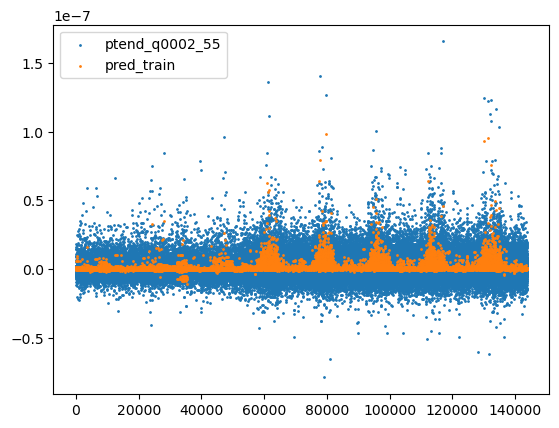

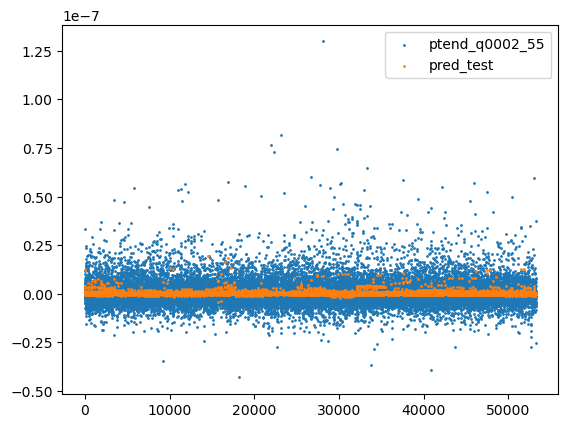

In [24]:
""" in feature space """

plt.scatter(x=range(train.shape[0]),y=train[f], s=1,label=f)#
plt.scatter(x=range(train.shape[0]),y=predTrain, s=1,label='pred_train')
plt.legend()
plt.show()


plt.scatter(x=range(val.shape[0]),y=val[f], s=1,label=f)
plt.scatter(x=range(val.shape[0]),y=predVal, s=1,label='pred_test')

plt.legend()
plt.show()

# --------- q0001_17 -------- + 500 rounds
# with both weights added: r2 scores 0.620568128775495 -12.886684419310917
# with only bin weight:    r2 scores 0.38436556429906865 -7.106889138729176

# only bin weight + filtered large Value; r2 scores 0.970014629131281 -30.927699550397456

# sampled dataframe based on bin, no weight:  r2 scores 0.38266688119407166 -6.823952224204593
# just with base train                        r2 scores 0.00028948769681691466 -0.2786449039559715 (overfitting to small)

# with combined dataset (base + large) + weight on most present values (weight bin): r2 scores 0.47950134306791525 0.6855532998108045
# ---------- q0002_26 -> r2 scores 0.02585576237677234 -51300468.90005738
# ---------- q0002_55 -> r2 scores 0.34149618806312454 0.20295038599831794 
#          vs. no weight r2 scores 0.5742472558817069 0.2637853592121119
#          vs. gen. w.   r2 scores 0.14178433197738105 0.057605530753293555   weighting general classes higher doesn't work here
#          vs. gen NormW r2 scores -7.9934196806235605 -2.78584707950082      weighting all bins equally over all data
# ---------- v_40     -> r2 scores 0.7183322716895276 0.14744326258943963  
#          vs. no weight r2 scores 0.8110174263472736 -0.06821487955466332 
#          vs. sampled   r2 scores 0.577485223064574 -1.0037809995502571
#          vs. gen w.    r2 scores 0.5531406564564257 0.4065882095204236      general weight on all data


TODO: define weighting base on:
- how many samples are in the respective dimension: build histogram over pos & negative samples + 0 -> equally weight all of them
- z score of samples -> the larger the more important

# test weighted lgbm

In [ ]:
f = 'ptend_q0001_17'

filtered = largeV.loc[abs(largeV[f]) >= abs(meanDict[f])]
filtered = largeV.loc[(largeV[f] >= (meanDict[f] + 20*stdDict[f])) | (largeV[f] <= (meanDict[f] - 20*stdDict[f]))]
print(filtered.shape, largeV.shape)
#train = pd.concat([baseTrain,largeV_f], axis = 0)
#train = pd.concat([baseTrain,largeV_26], axis = 0)
train = pd.concat([baseTrain,filtered], axis = 0)
#train = pd.concat([baseTrain,largeV], axis = 0)

valSet = lgb.Dataset(val[allF], label=val[f], free_raw_data=False)
weight = (((train[f] - meanDict[f])/stdDict[f])**2)#specific weighting based on feature
weight = abs(((train[f] - meanDict[f])/stdDict[f]))
#weight = weight / min(weight)
trainSet = lgb.Dataset(train[allF], train[f], weight=train['weight'], free_raw_data=False)

In [ ]:


params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    #'num_leaves': 15,
    #'learning_rate': 0.05,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'verbose': 1
}


gbm = None

gbm = lgb.train(params,
            trainSet,
            num_boost_round=500, 
            valid_sets=valSet,
            init_model=gbm)

predTrain = gbm.predict(train[allF])
predVal = gbm.predict(val[allF])
r2train =r2_score(train[f], predTrain)
r2test =r2_score(val[f], predVal)
print('r2 scores', r2train,r2test)# 'transormed',r2_score(train[transfF], predTrain0),r2_score(val[transfF], predVal0))

In [ ]:
""" in feature space """
plt.scatter(x=range(train.shape[0]),y=predTrain, s=1,label='pred_train')
plt.scatter(x=range(train.shape[0]),y=train[f], s=1,label=f)
plt.legend()
plt.show()

plt.scatter(x=range(val.shape[0]),y=predVal, s=1,label='pred_test')
plt.scatter(x=range(val.shape[0]),y=val[f], s=1,label=f)

plt.legend()
plt.show()

# test transformed lgbm

In [ ]:
f = 'ptend_q0001_17'
minValue = minDict[f]['min']
transfF = f+'_transf'

filtered = largeV.loc[abs(largeV[f]) >= abs(meanDict[f])]
print(filtered.shape, largeV.shape)
#train = pd.concat([baseTrain,largeV_f], axis = 0)
#train = pd.concat([baseTrain,largeV_26], axis = 0)
#train = pd.concat([baseTrain,filtered], axis = 0)
train = pd.concat([baseTrain,largeV], axis = 0)

train[transfF] = custom_log_2(train[f].copy(), minValue=minValue)
val[transfF] = custom_log_2(val[f].copy(), minValue=minValue)

valSet = lgb.Dataset(val[allF], label=val[transfF], free_raw_data=False)
weight = (((train[f] - meanDict[f])/stdDict[f])**2)#specific weighting based on feature
weight = abs(((train[f] - meanDict[f])/stdDict[f]))
weight = weight / min(weight)



In [78]:
transfF = f + '_transf'
sampled[transfF] = custom_log_2(sampled[f].copy(), minValue=minDict[f]['min'])
val[transfF] = custom_log_2(val[f].copy(), minValue=minDict[f]['min'])

sub = sampled.loc[sampled[f]>0]
subV = val.loc[val[f]>0]

trainSet = lgb.Dataset(sub[allF], sub[transfF])#, weight=train['weight'], free_raw_data=False)
valSet = lgb.Dataset(subV[allF], label=subV[transfF], free_raw_data=False)

In [90]:
train = pd.concat([baseTrain, largeV], axis=0)
transfF = f + '_transf'
train[transfF] = custom_log_2(train[f].copy(), minValue=minDict[f]['min'])
val[transfF] = custom_log_2(val[f].copy(), minValue=minDict[f]['min'])

train['weight'] = (train[f]-meanDict[f])**2

#sub = train.loc[train[f]>0]
#subV = val.loc[val[f]>0]
sub = train.copy()



#artivicially move values into positive
minValTransfF = abs(sub[transfF].min())
sub[transfF] = sub[transfF] + minValTransfF
subV[transfF] = subV[transfF] + minValTransfF

trainSet = lgb.Dataset(sub[allF], sub[transfF])#, weight=sub['weight']/sub['weight'].max(), free_raw_data=False)
valSet = lgb.Dataset(subV[allF], label=subV[transfF], free_raw_data=False)

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_3185/2929125557.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[transfF] = sub[transfF] + minValTransfF
/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_3185/2929125557.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subV[transfF] = subV[transfF] + minValTransfF


In [91]:

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    #'num_leaves': 15,
    #'learning_rate': 0.05,
    #'feature_fraction': 0.9,
    #'bagging_fraction': 0.8,
    #'bagging_freq': 5,
    'verbose': 1
}


gbm = None

gbm = lgb.train(params,
            trainSet,
            num_boost_round=200, 
            valid_sets=valSet,
            init_model=gbm)

predTrain0 = gbm.predict(sub[allF])
predVal0 = gbm.predict(subV[allF])
predTrain = inv_custom_log_2(predTrain0- minValTransfF, minDict[f]['min'])
predVal = inv_custom_log_2(predVal0-minValTransfF, minDict[f]['min'])
r2train =r2_score(sub[f], predTrain)
r2test =r2_score(subV[f], predVal)
print('r2 scores', r2train,r2test, 'transormed',r2_score(sub[transfF], predTrain0),r2_score(subV[transfF], predVal0))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112115
[LightGBM] [Info] Number of data points in the train set: 51769, number of used features: 481
[LightGBM] [Info] Start training from score 3.788482
r2 scores 0.28993980731919133 0.23410064002653397 transormed 0.44342800425357576 0.2896518406462254


In [51]:
# -- sampled df based on appearance of log bin --
# r2 scores -1.020903606711506e+24 -7.581554632036056e+62 transormed 0.8766614556749107 -0.33763598112642224 for pos & neg combined
# only neg r2 scores 0.9793021057704979 0.1083071275219144 transormed 0.9998079910715847 0.8642807598716907
# only pos r2 scores 0.9474206185787832 -0.1449953254940295 transormed 0.9673479159593839 -0.5581621512878674

# -- base train + largeV combined -> favours small values since small values are more negative
# only pos r2 scores 0.2902795912350017 0.23251028659873052 transormed 0.4429164260915328 0.28999340730533507
# -- base train + largeV combined + weight on l2 level
# only pos r2 scores 0.1161499432053914 -0.15974208166744686 transormed -0.410610741392758 -0.5091970274979973
# -- base train + largeV combined + transformed to positive to favour large values
# only pos r2 scores 0.28993980731919133 0.23410064002653397 transormed 0.44342800425357576 0.2896518406462254
f = 'ptend_q0002_55'
transfF = f + '_transf'
itransfF = 'inv_'+transfF
sub[transfF] = custom_log_2(sub[f].copy(), minValue=minDict[f]['min'])
sub[itransfF] = inv_custom_log_2(sub[transfF], minDict[f]['min'])
sub[[f,transfF,itransfF]]

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_3185/684921111.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[transfF] = custom_log_2(sub[f].copy(), minValue=minDict[f]['min'])
/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_3185/684921111.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub[itransfF] = inv_custom_log_2(sub[transfF], minDict[f]['min'])


,ptend_q0002_55,ptend_q0002_55_transf,inv_ptend_q0002_55_transf
3436,1.077893e-08,-178.368879,1.077893e-08
3007,1.196884e-08,-178.473592,1.196884e-08
1858,1.116122e-08,-178.403731,1.116122e-08
3198,1.090863e-08,-178.380840,1.090863e-08
1295,1.296307e-08,-178.553391,1.296307e-08
...,...,...,...
2847,3.838420e-14,-165.823421,3.838420e-14
2847,3.838420e-14,-165.823421,3.838420e-14
2847,3.838420e-14,-165.823421,3.838420e-14
2847,3.838420e-14,-165.823421,3.838420e-14


In [ ]:
train['prediction_log'] = predTrain0
train['prediction_feat'] = predTrain

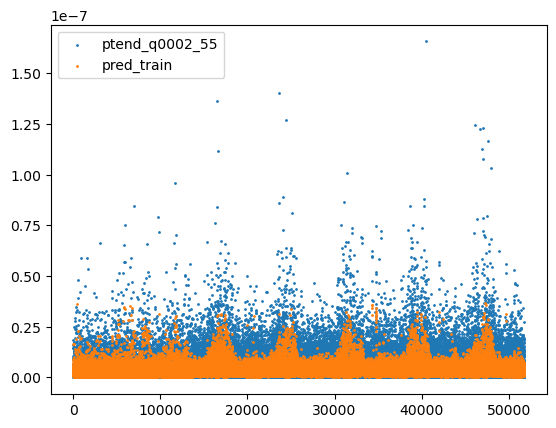

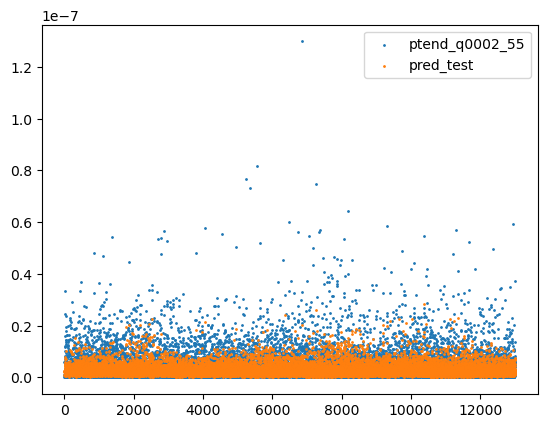

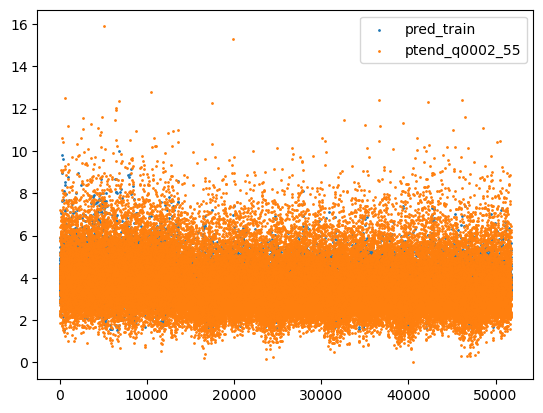

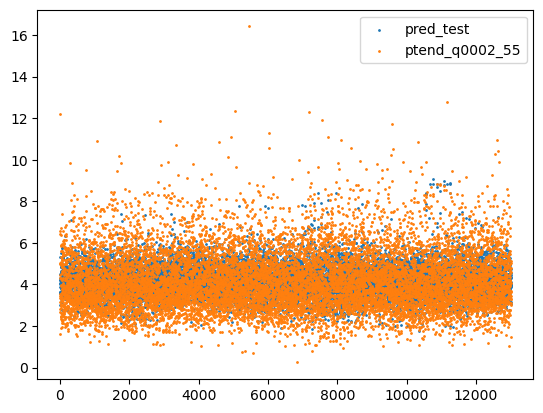

In [92]:
""" in feature space """
plt.scatter(x=range(sub.shape[0]),y=sub[f], s=1,label=f)
plt.scatter(x=range(sub.shape[0]),y=predTrain, s=1,label='pred_train')
plt.legend()
plt.show()

plt.scatter(x=range(subV.shape[0]),y=subV[f], s=1,label=f)
plt.scatter(x=range(subV.shape[0]),y=predVal, s=1,label='pred_test')
plt.legend()
plt.show()

""" in transformed space """
plt.scatter(x=range(sub.shape[0]),y=predTrain0, s=1,label='pred_train')
plt.scatter(x=range(sub.shape[0]),y=sub[transfF], s=1,label=f)
plt.legend()
plt.show()

plt.scatter(x=range(subV.shape[0]),y=predVal0, s=1,label='pred_test')
plt.scatter(x=range(subV.shape[0]),y=subV[transfF], s=1,label=f)
plt.legend()
plt.show()

In [39]:
predTrain

array([-5.26275777e-75, -1.44704857e-75, -2.76070677e-75, ...,
       -3.87833554e-70, -3.87833554e-70, -3.87833554e-70])

#  correlation between targets
- only targets close to each other are strongly correlated
- some have correlations to other variables as well
- weak correlation of features to targets (no surprise)

In [ ]:
q0002_f = []
for i in range(60):
    if i <12:
        continue
    q0002_f.append('ptend_q0003_'+str(i))

In [ ]:
allF

In [ ]:
corrMat = train[allF].corr()

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(corrMat)
plt.title(f"Correlation Matrix")
plt.show()

In [ ]:
pd.set_option('display.max_rows',None)
corrMat['ptend_q0003_17']

# simple LGBMs

In [ ]:
targetsToPredict = ['ptend_q0001_16 - 21', 37-59,  'ptend_q0002_15-27, 31-55', 'ptend_q0003_15-49'
                    'ptend_t_19, 45-58','ptend_u_23-47','ptend_v_23-37'
                    ]

In [9]:
zscoreDict

{'ptend_t_0': {'min': -63.21447975879488, 'max': 245.67247936945668},
 'ptend_t_1': {'min': -85.03918460626298, 'max': 485.3715638134578},
 'ptend_t_2': {'min': -126.60629741789786, 'max': 68.02051460930264},
 'ptend_t_3': {'min': -63.63672121888045, 'max': 2.8775431157252003},
 'ptend_t_4': {'min': -3.6853286303219415, 'max': 2.1461468624645654},
 'ptend_t_5': {'min': -2.5782653965224633, 'max': 2.294037629450322},
 'ptend_t_6': {'min': -2.0357513955629463, 'max': 2.657069630332726},
 'ptend_t_7': {'min': -2.546213690396981, 'max': 2.971244695190985},
 'ptend_t_8': {'min': -2.530318347897266, 'max': 3.1563311665414484},
 'ptend_t_9': {'min': -2.450968150453563, 'max': 3.372380426837497},
 'ptend_t_10': {'min': -2.5501623751607663, 'max': 3.3834928657381136},
 'ptend_t_11': {'min': -2.5926513754892664, 'max': 3.3065237327024843},
 'ptend_t_12': {'min': -2.620270894761342, 'max': 3.3768677441385972},
 'ptend_t_13': {'min': -2.971609148196438, 'max': 3.2113149540255908},
 'ptend_t_14': {